In [2]:
import os
import pandas as pd
import numpy as np
from UsefulFunctionsForModels import *
from scipy.optimize import minimize, linear_sum_assignment
from PlotsProject import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
path='price_history/high_sales'

In [5]:
df=get_dataframe_cards_matrix(path)

Error reading card sm10-130_Holofoil: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte


/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [6]:
class MarkowitzOptimizer:
    def __init__(self, amount_to_invest, hope_return, dataframe_cards_info):
        self.amount_to_invest = amount_to_invest
        self.hope_return = hope_return
        self.dataframe_cards_info = dataframe_cards_info
    
    def get_optimized_return_mean_matrix_fiability(self, threshold=0.01, ratio=0.40):
        filtered_df = self.dataframe_cards_info[
            (self.dataframe_cards_info["fiability_dot_return"] > threshold) & 
            (self.dataframe_cards_info['last_price'] < ratio * self.amount_to_invest)
        ]
        return filtered_df

    def objective_weights(self, weights):
        filtered_df = self.get_optimized_return_mean_matrix_fiability()
        covariance_filtered_cards = calculate_covariance_matrix(filtered_df,path)
        return np.dot(weights.T, np.dot(covariance_filtered_cards, weights))
    
    def set_constraints(self):
        filtered_df = self.get_optimized_return_mean_matrix_fiability()
        mean_matrix = filtered_df["fiability_dot_return"].values  # Convertir en array numpy
        n_cards = len(mean_matrix)
                
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            #{'type': 'ineq', 'fun': lambda x: np.dot(x, mean_matrix) - 0.9 * self.hope_return},  
            #{'type': 'ineq', 'fun': lambda x: 1.1 * self.hope_return - np.dot(x, mean_matrix)}  
        ]
        
        bounds = tuple((0, 1) for _ in range(n_cards))
        return constraints, bounds
    
    def optimize_portfolio(self):
        filtered_df = self.get_optimized_return_mean_matrix_fiability()
        n_cards = len(filtered_df)
        
        if n_cards == 0:
            raise ValueError("Aucune carte ne correspond aux critères de filtrage")
        
        constraints, bounds = self.set_constraints()
        initial_weights = np.array([1/n_cards] * n_cards)
        
        result = minimize(
            self.objective_weights, 
            initial_weights, 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints
        )
        
        
        return result.x, filtered_df

    def optimize_cards_sell(self):
        df = self.get_optimized_return_mean_matrix_fiability()
        prices = df["last_price"].values
        #cards_ids=df["card_id"]
        weights, _ = self.optimize_portfolio()
        
        sorted_indices = np.argsort(weights)[::-1]
        
        total_investment = 0
        selected_indices = []
        
        for idx in sorted_indices:
            if total_investment + prices[idx] <= self.amount_to_invest:
                total_investment += prices[idx]
                selected_indices.append(idx)
            else:
                if abs(self.amount_to_invest - (total_investment + prices[idx])) < abs(self.amount_to_invest - total_investment):
                    total_investment += prices[idx]
                    selected_indices.append(idx)
                break
        
        binary_selection = np.zeros(len(weights))
        binary_selection[selected_indices] = 1
        mean_return= np.mean(df.iloc[selected_indices]["fiability_dot_return"])
        
        return total_investment,  mean_return, df.iloc[selected_indices]

In [7]:
amount=200
hope=100
markowitz=MarkowitzOptimizer(amount,hope,df)

In [8]:
mu=markowitz.get_optimized_return_mean_matrix_fiability()

In [9]:
mu

,card_id,last_price,mean_return,fiability,fiability_dot_return
6,sm7-181_Holofoil,5.89,0.02,0.999980,0.020000
12,xyp-XY114_Holofoil,6.44,0.14,1.000000,0.140000
20,sm6-143_Holofoil,35.88,0.06,0.999254,0.059955
22,ex13-106_Holofoil,7.91,0.04,1.000000,0.040000
30,xy6-101_Holofoil,14.65,0.02,1.000000,0.020000
32,xyp-XY81_Holofoil,9.89,0.02,1.000000,0.020000
47,sm5-163_Holofoil,21.10,0.03,0.997527,0.029926
49,sm12-22_Holofoil,9.75,0.34,1.000000,0.340000
51,hsp-HGSS15_Holofoil,6.22,0.25,0.858149,0.214537
52,ex9-24_Normal,2.47,0.28,0.858149,0.240282


In [3]:
a=markowitz.optimize_cards_sell()

NameError: name 'markowitz' is not defined

In [43]:
a[0],a[1]

(218.06000000000003, 0.21753679195205045)

In [45]:
a[2]

,card_id,last_price,mean_return,fiability,fiability_dot_return
52,ex9-24_Normal,2.47,0.28,0.858149,0.240282
111,sm8-149_Holofoil,5.46,0.03,1.000000,0.030000
96,xyp-XY170_Holofoil,7.35,0.02,0.993940,0.019879
6,sm7-181_Holofoil,5.89,0.02,0.999980,0.020000
12,xyp-XY114_Holofoil,6.44,0.14,1.000000,0.140000
122,xyp-XY107_Holofoil,6.74,0.11,1.000000,0.110000
22,ex13-106_Holofoil,7.91,0.04,1.000000,0.040000
47,sm5-163_Holofoil,21.10,0.03,0.997527,0.029926
20,sm6-143_Holofoil,35.88,0.06,0.999254,0.059955
61,dp2-1_Holofoil,5.76,0.92,0.937027,0.862065


In [92]:
cov=calculate_covariance_matrix(a[1],path)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<module 'matplotlib.pyplot' from '/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/matplotlib/pyplot.py'>

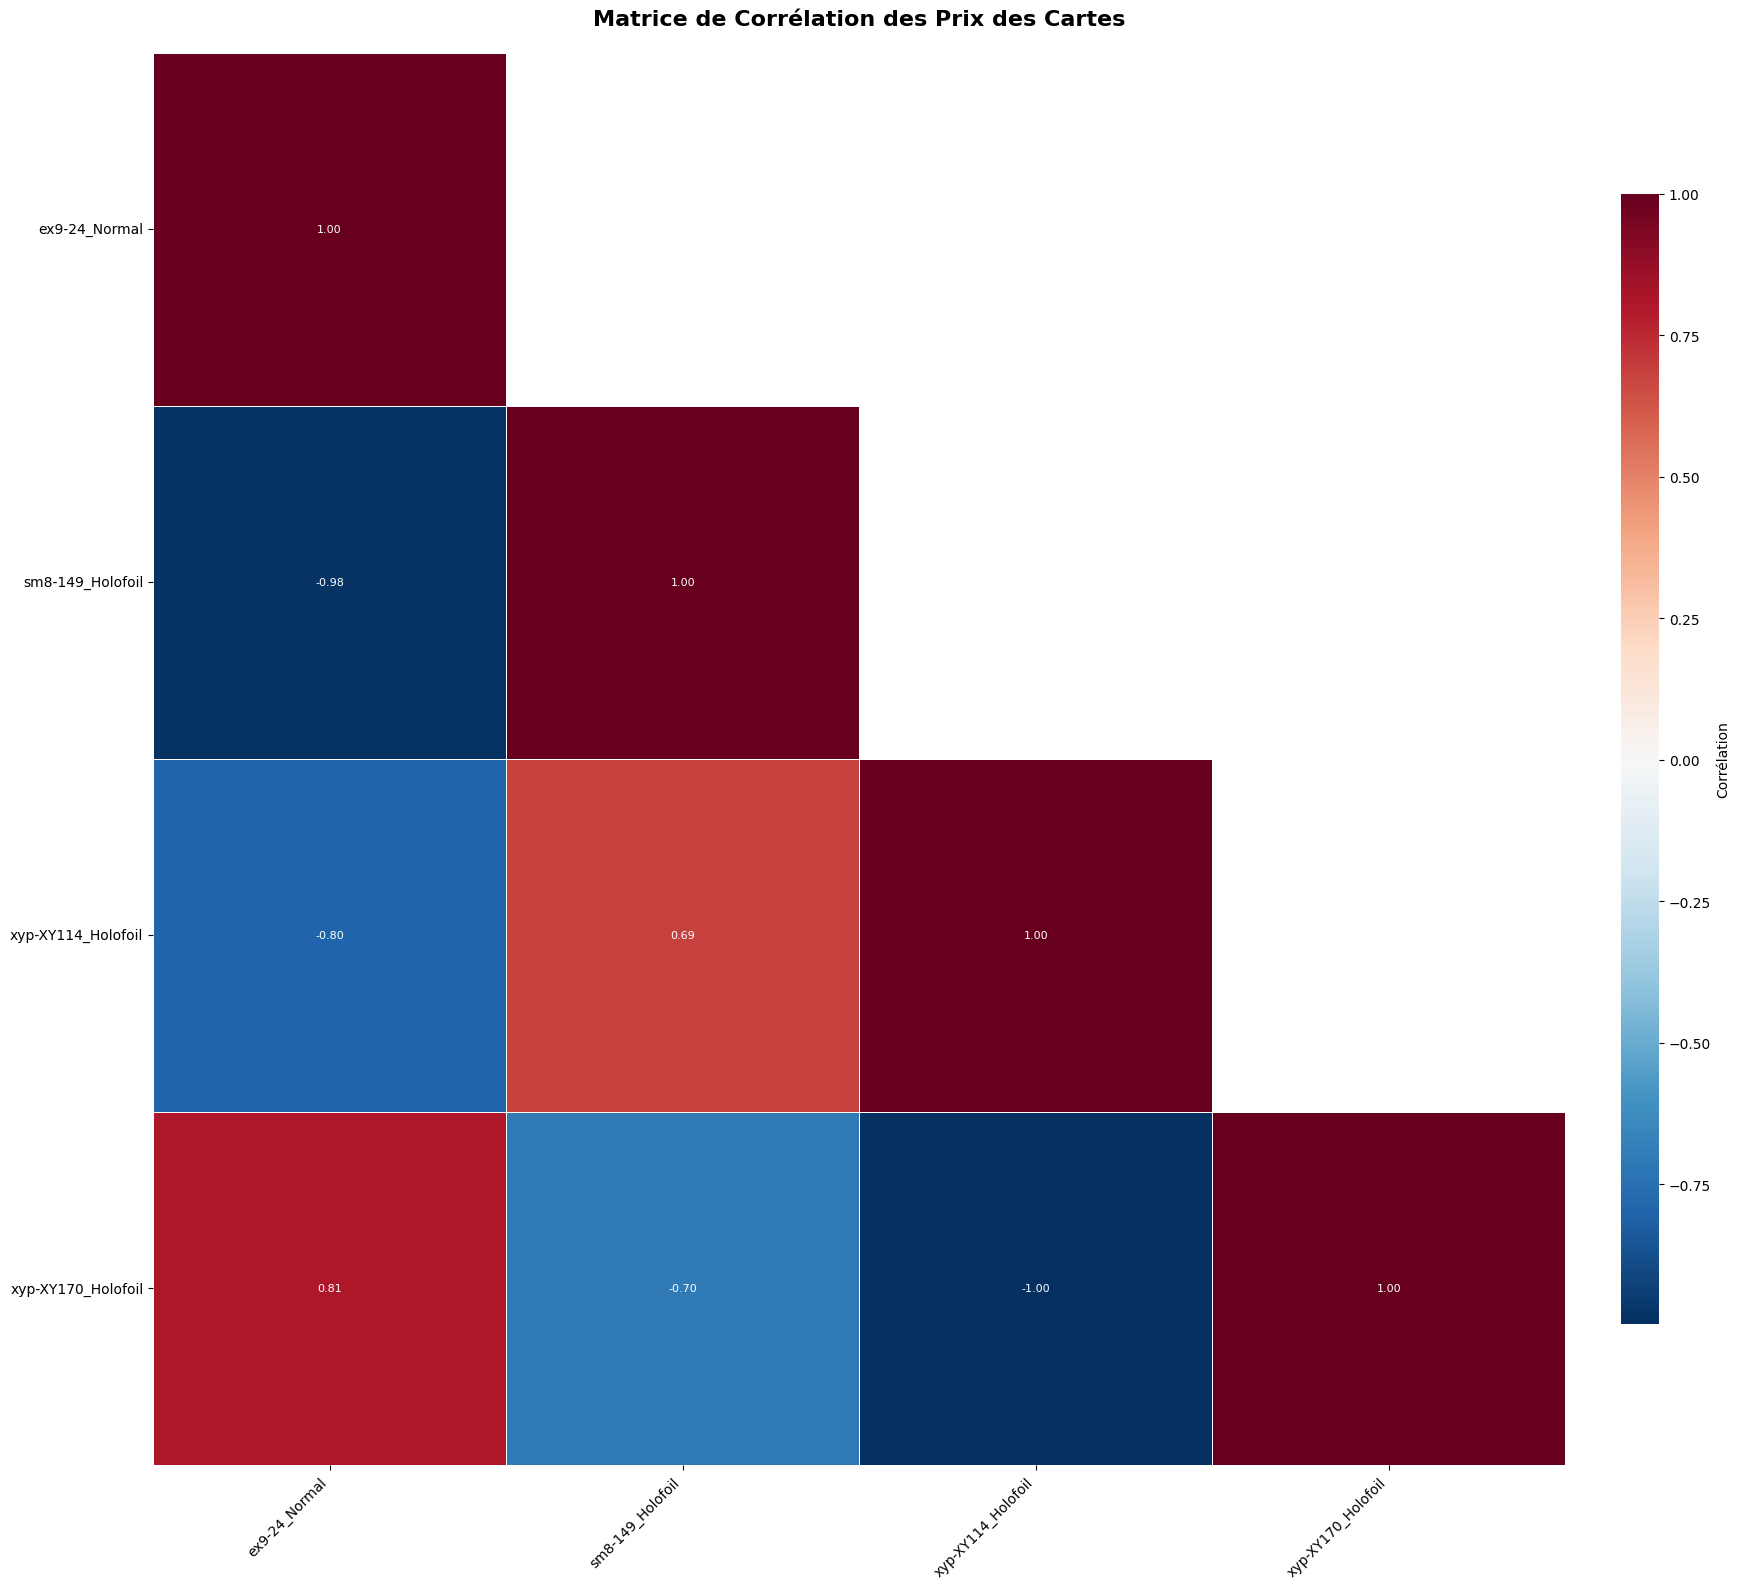

In [93]:
plot_covariance_heatmap(cov)

In [10]:
filtered=markowitz.get_optimized_return_mean_matrix_fiability()

In [11]:
filtered

,card_id,last_price,mean_return,fiability,fiability_dot_return
6,sm7-181_Holofoil,5.89,0.02,0.999980,0.020000
12,xyp-XY114_Holofoil,6.44,0.14,1.000000,0.140000
20,sm6-143_Holofoil,35.88,0.06,0.999254,0.059955
22,ex13-106_Holofoil,7.91,0.04,1.000000,0.040000
30,xy6-101_Holofoil,14.65,0.02,1.000000,0.020000
32,xyp-XY81_Holofoil,9.89,0.02,1.000000,0.020000
47,sm5-163_Holofoil,21.10,0.03,0.997527,0.029926
49,sm12-22_Holofoil,9.75,0.34,1.000000,0.340000
51,hsp-HGSS15_Holofoil,6.22,0.25,0.858149,0.214537
52,ex9-24_Normal,2.47,0.28,0.858149,0.240282


In [12]:
from MarkowitzPortfolioOptimizer import MarkowitzOptimizer
from UsefulFunctionsForModels import get_dataframe_cards_matrix

In [13]:
path='price_history/high_sales'
amount=100
df=get_dataframe_cards_matrix(path)

Error reading card sm10-130_Holofoil: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte


/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [14]:
marko=MarkowitzOptimizer(amount_to_invest=amount,dataframe_cards_info=df)

In [15]:
a=marko.optimize_cards_sell()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [16]:
a[0]

99.24000000000001

In [17]:
a[1]

0.0766712396600279

In [18]:
a[2]

,card_id,last_price,mean_return,fiability,fiability_dot_return
52,ex9-24_Normal,2.47,0.28,0.858149,0.240282
111,sm8-149_Holofoil,5.46,0.03,1.000000,0.030000
96,xyp-XY170_Holofoil,7.35,0.02,0.993940,0.019879
6,sm7-181_Holofoil,5.89,0.02,0.999980,0.020000
12,xyp-XY114_Holofoil,6.44,0.14,1.000000,0.140000
122,xyp-XY107_Holofoil,6.74,0.11,1.000000,0.110000
22,ex13-106_Holofoil,7.91,0.04,1.000000,0.040000
47,sm5-163_Holofoil,21.10,0.03,0.997527,0.029926
20,sm6-143_Holofoil,35.88,0.06,0.999254,0.059955


In [ ]:
def retrieve_card_names(df, csv="pokemon_cards.csv"):
    for id in df["card_id"] : 
        